# Part 2 - **Transformacions**

En aquest notebook seguirem amb les mateixes xarxes utilitzades al notebook anterior (``resnet18``,  ``resnet50``,  ``resnet152``) però aplicant transformacions a les imatges per tal d'intentar millorar els resultats.

### **1. Carregar Imatges**

Comencem important les llibreries que necessitarem durant aquest Notebook. El codi següent està pensat per executar el notebook en un ordinador local:

In [2]:
### PYCHARM ###

import fastai
import torch
from fastai.vision.all import *
from fastai.callback.fp16 import *


from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch


path = "dataset_CIFAR10"


En cas de voler executar-lo des de Google Colab, les llibreries són les següents:

In [2]:
### COLAB ###
"""
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.callback.fp16 import *

!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip
path = "/content/"
"""

'\n! [ -e /content ] && pip install -Uqq fastbook\nimport fastbook\nfrom fastbook import *\nfastbook.setup_book()\nfrom fastai.callback.fp16 import *\n\n!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip\npath = "/content/"\n'

Comprovem que la GPU s'hagi detectat correctament:

In [3]:
#check if cuda is available
torch.cuda.is_available()

True

Ara sí, creem l'objecte ``ImageDataLoader`` per carregar les imatges a la xarxa neuronal. En aquest cas, hem afegit una transformació de batch, ``batch_tfms=aug_transforms(size=224, min_scale=0.75)``. Amb això estem fent diferents coses. La primera és que estem **redimensionant les imatges a 224x224**, que és la mida amb què s'ha entrenat les xarxes Resnet (``size=224``). A part d'això, hem definit també  ``min_scale=0.75``, (hem extret aquest valor [d'aquest notebook](https://github.com/rmartimarly/teaching_misc/blob/main/05_pet_breeds.ipynb), i ens ha donat bon resultat). Per la resta de possibles paràmetres de transformacions, apliquem els que venen per defecte a Fastai.

In [4]:
dls = ImageDataLoaders.from_folder(
    path=path,
    train='train',
    valid='validation',
    seed=42,
    bs = 64,
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

### **2. Resnet18**

In [6]:
learn18 = vision_learner(dls, resnet18, metrics=[accuracy, error_rate]).to_fp16()
learn18.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.609067,0.518113,0.822400,0.177600,01:29
1,0.536806,0.456162,0.843100,0.156900,01:29
2,0.424992,0.360257,0.874500,0.125500,01:29
3,0.339027,0.357880,0.878800,0.121200,01:26
4,0.245468,0.303170,0.896400,0.103600,01:24
5,0.226316,0.308927,0.896400,0.103600,01:25


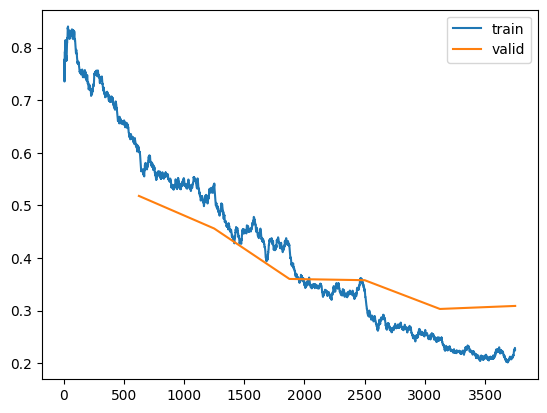

In [7]:
#plot loss and accuracy
learn18.recorder.plot_loss()

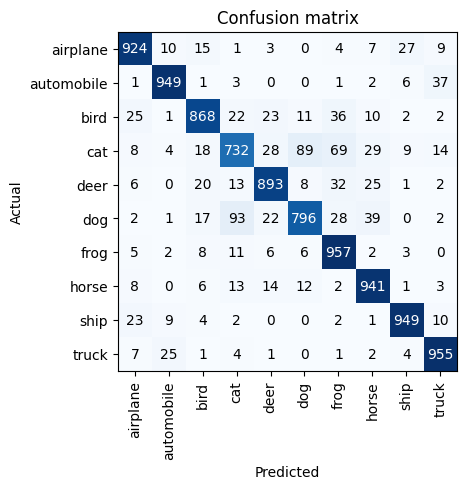

In [8]:
#plot confusion matrix
interp18 = ClassificationInterpretation.from_learner(learn18)
interp18.plot_confusion_matrix()

Veiem com els resultats han sigut molt positius. **Hem reduït molt l'overfitting** (respecte quan no aplicàvem transformacions), i la **precisió en el dataset de validació és  del 90%** (quan abans era del 70%). Veiem com a canvi, el temps per epoch és molt superior (de 40 segons a 1 minut i mig). Novament, les imatges que confón més són les de gats i les de gossos, però ara també les de gats amb granotes.

### **3. Resnet50**

In [10]:
learn50 = vision_learner(dls, resnet50, metrics=[accuracy, error_rate]).to_fp16()
learn50.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.486703,0.423726,0.854000,0.146000,02:31
1,0.460968,0.382340,0.872700,0.127300,02:32
2,0.371074,0.320071,0.891500,0.108500,02:30
3,0.248934,0.301596,0.900100,0.099900,02:29
4,0.160128,0.248925,0.920600,0.079400,02:30
5,0.124860,0.233876,0.926600,0.073400,02:29


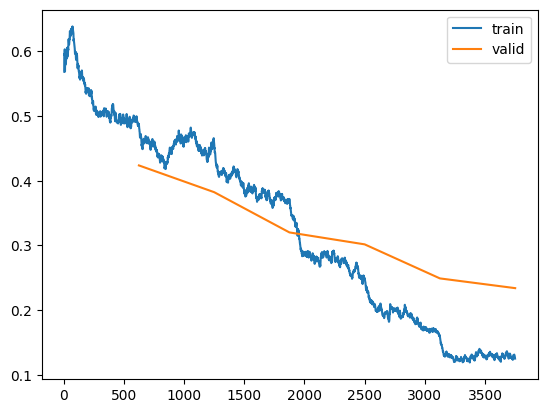

In [11]:
learn50.recorder.plot_loss()

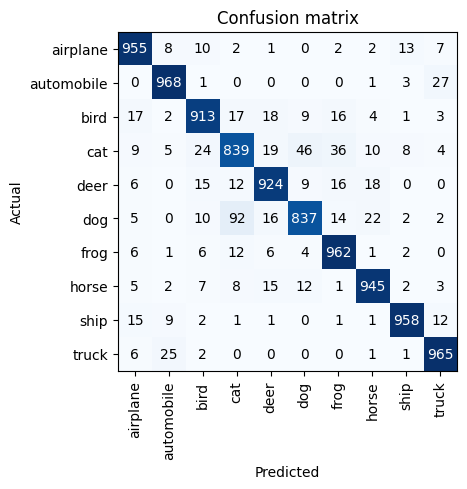

In [12]:
interp50 = ClassificationInterpretation.from_learner(learn50)
interp50.plot_confusion_matrix()

Amb una ``resnet50``, els resultats també són positius. L'overfitting és una mica més gran (però relativament poc), i hem arribat fins a un **92% de precisió**. El **temps per epoch, però, és ja de 2 minuts i mig** (quan amb una ``resnet50`` sense aplicar transformacions era de 50 segons, i amb una ``resnet18`` aplicant transformacions era de 1 minut i mig).

### **3. Resnet152**

In [14]:
learn152 = vision_learner(dls, resnet152, metrics=[accuracy, error_rate]).to_fp16()
learn152.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.434435,0.341582,0.882600,0.117400,04:53
1,0.409804,0.338352,0.885500,0.114500,04:57
2,0.338492,0.272367,0.909000,0.091000,04:56
3,0.217535,0.246453,0.919700,0.080300,04:58
4,0.119763,0.188964,0.937000,0.063000,04:55
5,0.080053,0.183093,0.940800,0.059200,04:56


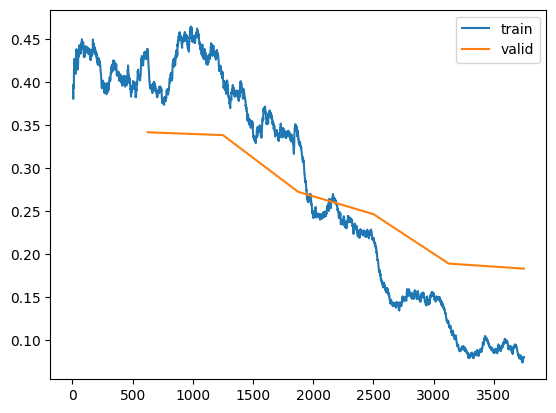

In [15]:
learn152.recorder.plot_loss()

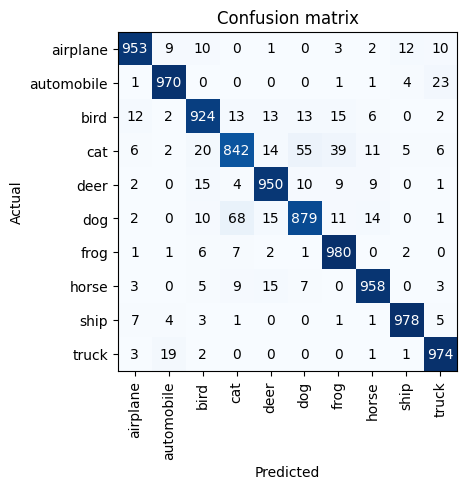

In [16]:
inter152 = ClassificationInterpretation.from_learner(learn152)
inter152.plot_confusion_matrix()

Veiem que utilitzant una ``resnet152`` hem reduït una mica l'overfitting respecte la ``resnet50``, i hem millorat el rendiment fins al **94% d'accuracy** (es continua equivocant amb gats i gossos, però en general ho fa prou bé). Això sí, tarda gairebé 5 minuts per epoch (recordem que quan no aplicavem transformacions tardava menys d'1 minut).

### **4. Altres tècniques de data augmentation**

Per tal de millorar els resultats, **provarem d'aplicar Mixup i CutMix** sobre el model ``resnet152`` (que tot i el temps, és el que ens ha donat millors resultats). La primera tècnica (Mixup) consisteix en combinar dues imatges (aplicant una combinació lineal entre les dues), mentre que CutMix consisteix en retallar una imatge de forma aleatòria i aquest retall es posa sobre d'una altra. A part de diferents transformacions, aplicarem la funció de pèrdua ``CrossEntropyLossFlat()`` (seguint [aquest tutorial](https://docs.fast.ai/callback.mixup.html)). Hem hagut de disminuïr la mida del batch de 64 a 32, ja que altrament ens quedavem sense memòria.

In [3]:
dls = ImageDataLoaders.from_folder(
    path=path,
    train='train',
    valid='validation',
    seed=42,
    bs = 32,
    batch_tfms=aug_transforms(size=224, min_scale=0.75, flip_vert=True, max_rotate=10.0, max_lighting=0.2, max_zoom=1.1, max_warp=0.2),
)

learn152 = vision_learner(dls, resnet152, metrics=[accuracy, error_rate], loss_func=CrossEntropyLossFlat())

C:\Users\joans\anaconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\joans\anaconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##### MixUp

Primer creem el ``mixup`` i visualitzem les imatges per veure com queden després d'aplicar la transformació:

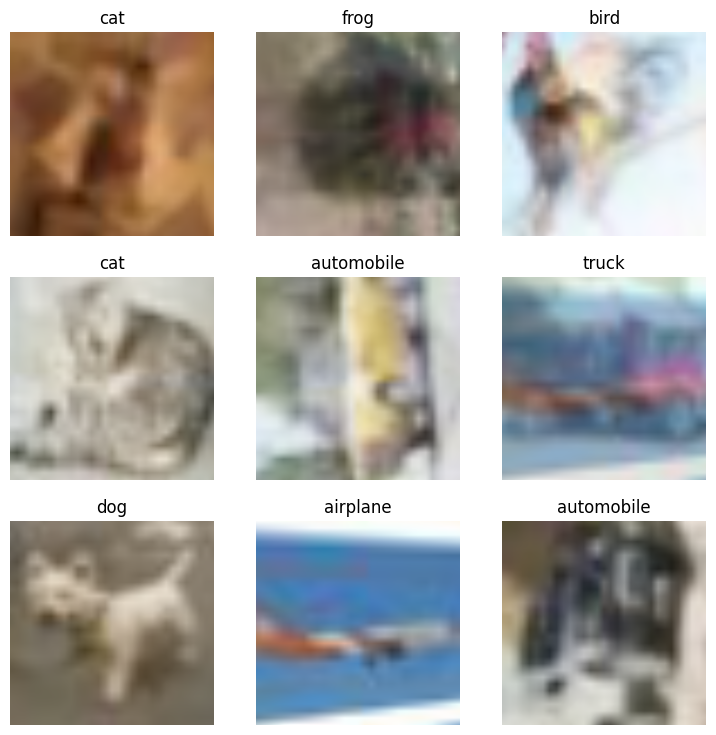

In [4]:
mixup = MixUp(1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

L'afegim al nostre dataloader i entrenem:

In [5]:
learn152.fine_tune(6, freeze_epochs=3, cbs=MixUp(1.))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.498025,0.635795,0.807900,0.192100,09:00
1,1.506092,0.670377,0.782300,0.217700,09:06
2,1.412091,0.543168,0.832400,0.167600,09:04
3,1.364665,0.453162,0.863400,0.136600,09:00
4,1.270793,0.359370,0.898100,0.101900,08:56
5,1.240896,0.340643,0.905000,0.095000,08:56


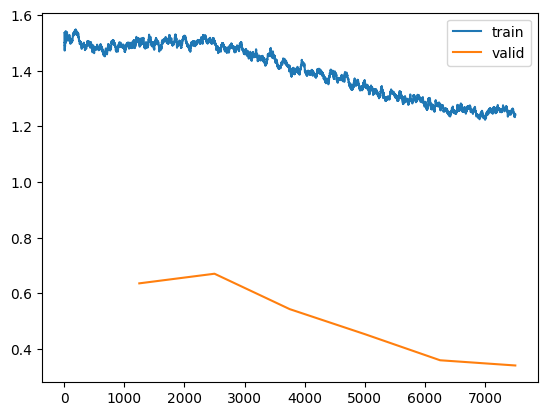

In [6]:
learn152.recorder.plot_loss()

Veiem com la cosa no acaba de funcionar. Tot i que la **precisió és prou bona (90%), estem fent underfitting** (la loss de la validació és inferior a la de  l'entrenament) i el **temps per epoch ara és de 10 minuts**. 

##### CutMix

De la manera que abans, primer creem l'objecte ``cutmix`` i visualitzem les imatges:

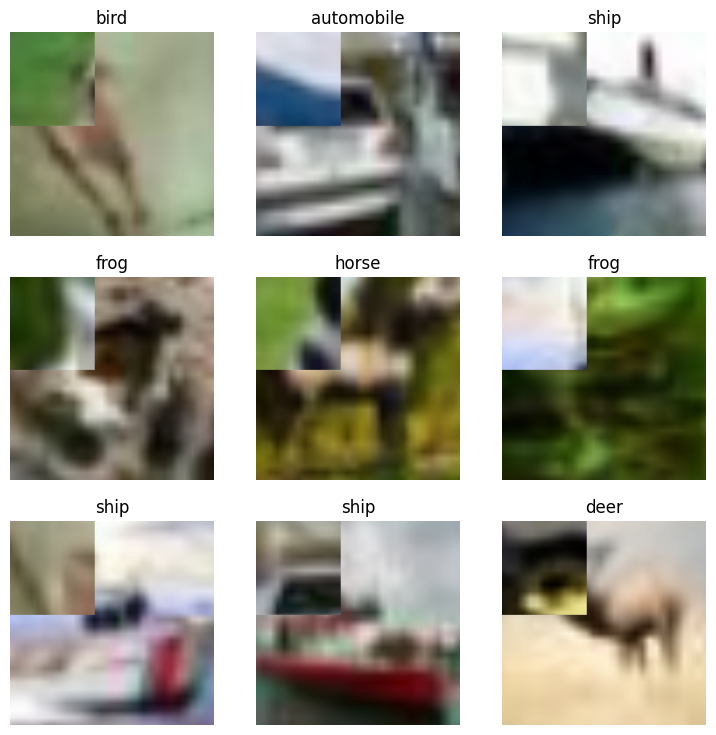

In [7]:
cutmix = CutMix(1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

I les afegim al nostre dataloader i entrenem:

In [8]:
learn152.fine_tune(6, freeze_epochs=3, cbs=CutMix(1.))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.349942,0.433313,0.886500,0.113500,08:59
1,1.305780,0.509019,0.841900,0.158100,09:12
2,1.311491,0.395495,0.890800,0.109200,08:58
3,1.207980,0.345767,0.899700,0.100300,08:58
4,1.165391,0.316823,0.910300,0.089700,09:12
5,1.104963,0.291551,0.917100,0.082900,09:00


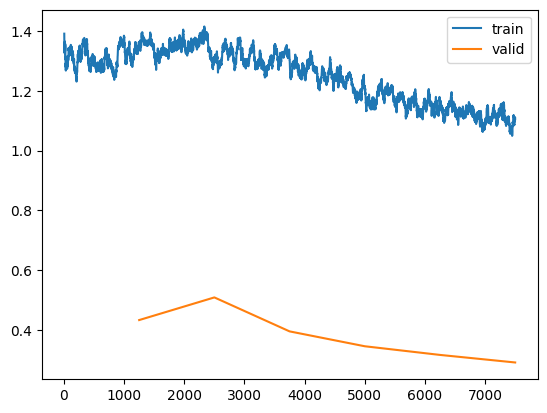

In [9]:
learn152.recorder.plot_loss()

Veiem com les conclusions són similars que apicant mixup: tot i que tenim una **bona accuracy (del 92%), estem cometent bastant underfitting**. El temps per epoch continua sent molt elevat.